# Total COVID-19 deaths for different Canadian provinces

Script produced by [Laurent Lessard](https://laurentlessard.com)

---

### Import data from covidtracking.com

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams['figure.dpi'] = 120

url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
df_raw = pd.read_csv(url)

### Reformat data into convenient form

In [2]:
colnames = df_raw.columns

# exctract Canada only, organize by province
df = df_raw[df_raw['Country/Region'] == 'Canada']
df = df.pivot_table(index='Province/State',values=colnames[4:],aggfunc=sum)

# drop cruise ships/misc.
df.drop(['Diamond Princess', 'Grand Princess'], axis='index', inplace=True)

# make countries columns rather than rows
df = df.T

# make the index a datetime object
df = df.reindex( pd.to_datetime(df.index) )

# sort the dates/times
df.sort_index(inplace=True)

# record the latest date
latest_date = df.index[-1].strftime("%a %b %d, %Y")
print(latest_date)

Wed May 20, 2020


### List of provinces with the most deaths

In [3]:
deaths_sorted = df.iloc[-1].sort_values(ascending=False)
deaths_sorted

Province/State
Quebec                       3719
Ontario                      2079
British Columbia              149
Alberta                       128
Nova Scotia                    57
Saskatchewan                    7
Manitoba                        7
Newfoundland and Labrador       3
Yukon                           0
Prince Edward Island            0
Northwest Territories           0
New Brunswick                   0
Name: 2020-05-20 00:00:00, dtype: int64

### List of states with at least 50 deaths

In [4]:
provs = df.columns[df.iloc[-1] >= 50]

for (i,c) in enumerate(provs):
    print( c.ljust(4), end=', ')
    if (i+1) % 12 == 0:
        print()

Alberta, British Columbia, Nova Scotia, Ontario, Quebec, 

### Plot shifted death toll for selected provinces

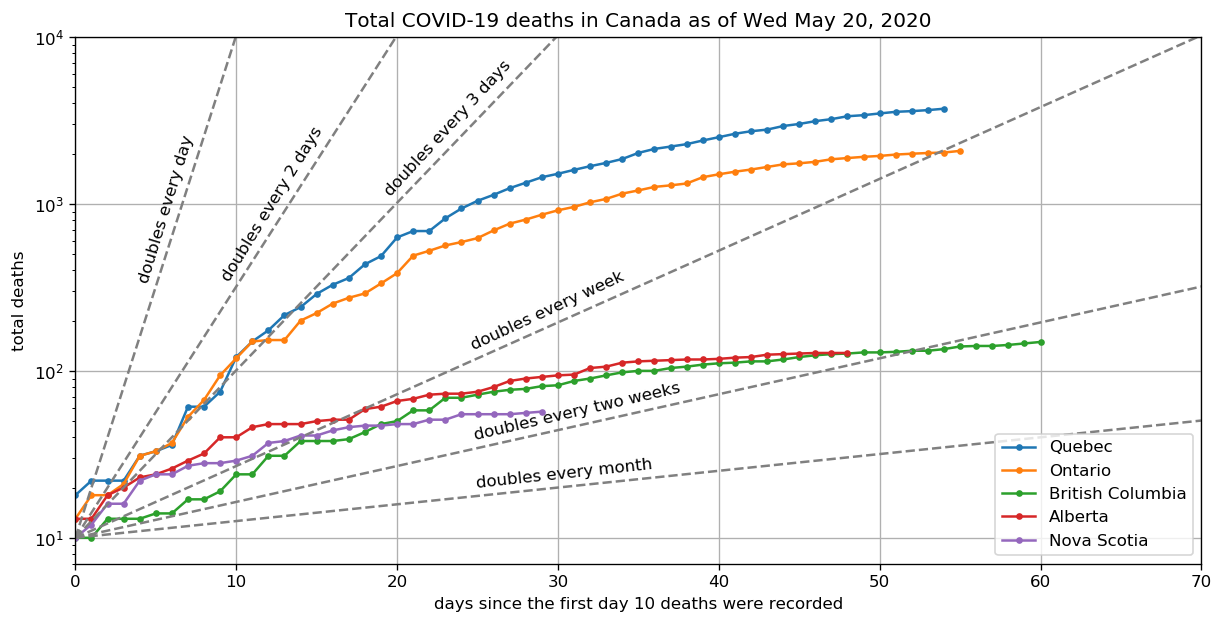

In [7]:
# function that shifts the data so everything starts from first min_deaths
def shift_data( states, min_deaths ):
    shifted_data = []
    for (c,data) in df[states].items():
        shifted_data.append( data[data >= min_deaths].reset_index(drop=True) )
    return shifted_data

# selected provinces
provs = deaths_sorted[:5].index
min_deaths = 10
xmax = 70

# shift data so that index corresponds to days since min_death deaths.
shifted_data = shift_data( provs, min_deaths )

# merge into a single dataframe
dfx = pd.concat( shifted_data, axis=1 )

# make plot
ax = dfx.plot(title="Total COVID-19 deaths in Canada as of %s" % latest_date, logy=True, figsize=(10,5), grid=True, marker='.');
ax.set_xlabel("days since the first day %g deaths were recorded" % min_deaths )
ax.set_ylabel("total deaths")
ax.set_ylim(min_deaths*.7,1e4)
ax.set_xlim(0,xmax)
ax.legend(loc="lower right")

# draw doubling lines (doubling every d days)
dvals = [1,2,3,7,14,30]    # values of doubling lines to draw (d)
dtxt = ["day", "2 days", "3 days", "week", "two weeks", "month"]
tloc = [5,10,20,25,25,25] # x-coordinate of text labels
for i,d in enumerate(dvals):
    tx = tloc[i]
    ty = min_deaths*(2**(tx/d))
    angle = np.arctan(ty/d * np.log(2))
    angle_screen = ax.transData.transform_angles(np.array([angle,]),np.array([[tx,ty]]),radians=True)[0]
    y = min_deaths*(2**(xmax/d))
    plt.plot([0,xmax],[min_deaths,y], '--', color='gray')
    ax.annotate("doubles every %s" % dtxt[i], xy=(tx,ty), xytext=(-5*np.sin(angle_screen),5*np.cos(angle_screen)),
                textcoords="offset points", rotation_mode='anchor', rotation=np.rad2deg(angle_screen))
plt.tight_layout(pad=0)
plt.savefig("figures/provinces_total_deaths_vs_time.png")